# Subspace BNN

In [1]:
import jax
import optax
import keras
import einops
import numpy as np
import pandas as pd
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
from functools import partial
from matplotlib import ticker
from flax.training.train_state import TrainState
from jax.flatten_util import ravel_pytree

from sklearn.decomposition import PCA
from sklearn.datasets import make_moons
from sklearn.metrics import confusion_matrix

from rebayes_mini import callbacks
from rebayes_mini.methods import replay_sgd
from rebayes_mini.methods import kalman_filter as kf
from rebayes_mini.methods import subspace_filter as skf
from rebayes_mini.methods import low_rank_filter as lofi

2023-10-21 15:29:58.659327: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Drop-in replacement

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
plt.style.use("dark_background")

acolors = [
    "#D9117F",
    "#0DD9D9",
    "#F2A30F",
    "#F26E22",
]

colors = list(v["color"] for v in plt.rcParams["axes.prop_cycle"])

In [4]:
key = jax.random.PRNGKey(314)

In [5]:
n_samples = 500
n_test = 300
data = make_moons(n_samples=(n_samples + n_test), random_state=3141, noise=0.15)
X, y = jax.tree_map(jnp.array, data)
X_test, y_test = X[-n_test:], y[-n_test:]
X, y = X[:-n_test], y[:-n_test]

key = jax.random.PRNGKey(314)

In [30]:
%%time
@skf.subcify
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x # sklearn


model = MLP(dim_in=2, dim_subspace=100)
params = model.init(key, X)

agent = skf.BernoulliFilter(
    model.apply,
    dynamics_covariance=1e-7
)

bel_init = agent.init_bel(params, cov=1.0)
bel, bel_hist = agent.scan(bel_init, y, X, callbacks.get_updated_mean)
bel = jax.block_until_ready(bel)
dim_full, _ = params["fixed"]["P"].shape

CPU times: user 1.14 s, sys: 13.1 ms, total: 1.15 s
Wall time: 646 ms


In [31]:
yhat = jax.nn.sigmoid(agent.link_fn(bel.mean, X_test)) > 0.5
(y_test == yhat.ravel()).mean()

Array(0.8933334, dtype=float32)

Text(0, 0.5, 'Weight value')

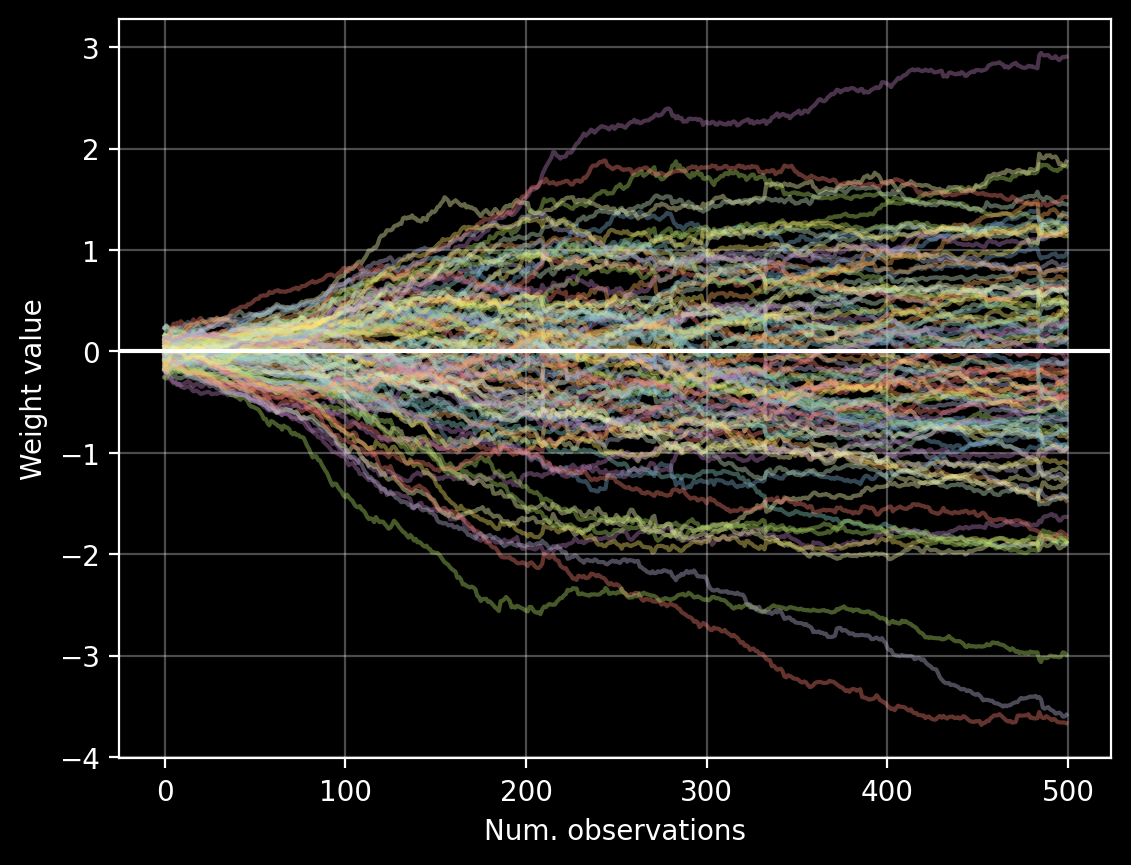

In [32]:
plt.plot(bel_hist, alpha=0.4)
plt.axhline(y=0, c="white")
plt.grid(alpha=0.3)
plt.xlabel("Num. observations")
plt.ylabel("Weight value")

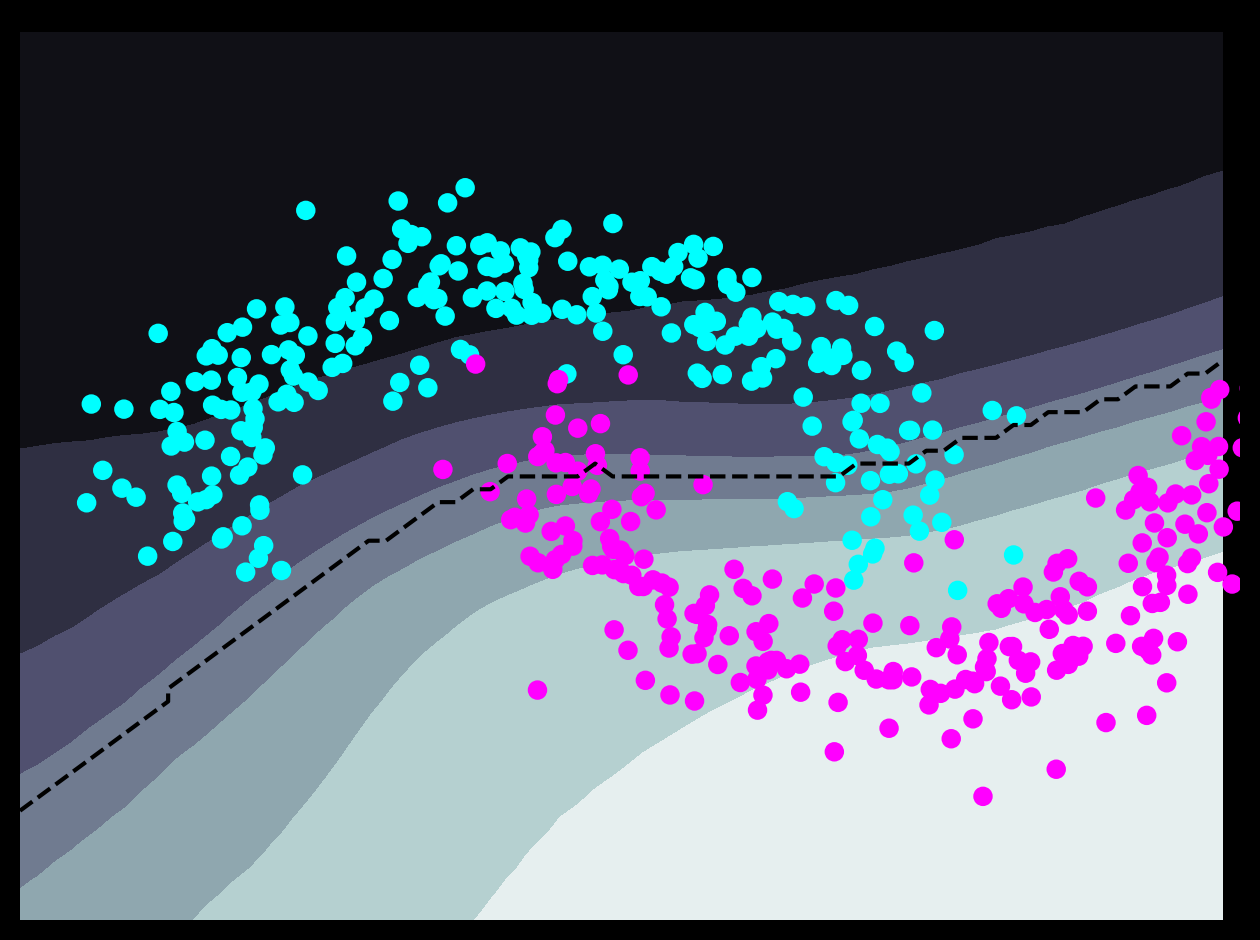

In [33]:
XX = np.mgrid[-1.5:2:0.05, -1.5:2:0.05]

Xeval = einops.rearrange(XX, "d x y -> x y d")

Z = agent.link_fn(bel.mean, Xeval).squeeze()
mean_Z = agent.mean(Z)

plt.contourf(*XX, mean_Z, cmap="bone")
plt.contour(*XX, mean_Z > 0.5, colors="black", linestyles="--")
plt.scatter(*np.array(X).T, c=y, cmap="cool")
plt.ylim(-1.5, 2)
plt.xlim(-1.5, 2)
plt.axis("off")
plt.tight_layout()

## Test accuracy as a function of subspace

In [12]:
%%time
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        x = nn.Dense(1)(x)
        return x # Eta


model = MLP()
params = model.init(key, X)

agent = kf.BernoulliFilter(
    model.apply,
    dynamics_covariance=0.0
)
bel_init = agent.init_bel(params, cov=0.1)
bel, _ = agent.scan(bel_init, y, X)
bel = jax.block_until_ready(bel)

CPU times: user 3.85 s, sys: 79.9 ms, total: 3.93 s
Wall time: 6.65 s


In [13]:
yhat = jax.nn.sigmoid(agent.link_fn(bel.mean, X_test)) > 0.5
acc_full = (y_test == yhat.ravel()).mean().item()
acc_full

0.9533333778381348

In [14]:
%%time
list_dim_subspace = np.arange(5, 155, 5)
SubMLP = skf.subcify(MLP)

n_runs = 15
results = []
keys = jax.random.split(key, n_runs)
for dim in tqdm(list_dim_subspace):
    model = SubMLP(dim_in=2, dim_subspace=dim)
    
    agent = skf.BernoulliFilter(
        model.apply,
        dynamics_covariance=0.0
    )
    
    @jax.vmap
    def eval_acc(key):
        params = model.init(key, X)
        bel_init = agent.init_bel(params, cov=2.0)
        bel, _ = agent.scan(bel_init, y, X)

        yhat = jax.nn.sigmoid(agent.link_fn(bel.mean, X_test)) > 0.5
        accuracy = (y_test == yhat.ravel()).mean()
        return accuracy
    
    accuracies = eval_acc(keys)
    results.append(accuracies)
results = pd.DataFrame(np.array(results), index=list_dim_subspace)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [08:38<00:00, 17.30s/it]


CPU times: user 10min 57s, sys: 7.96 s, total: 11min 5s
Wall time: 8min 39s


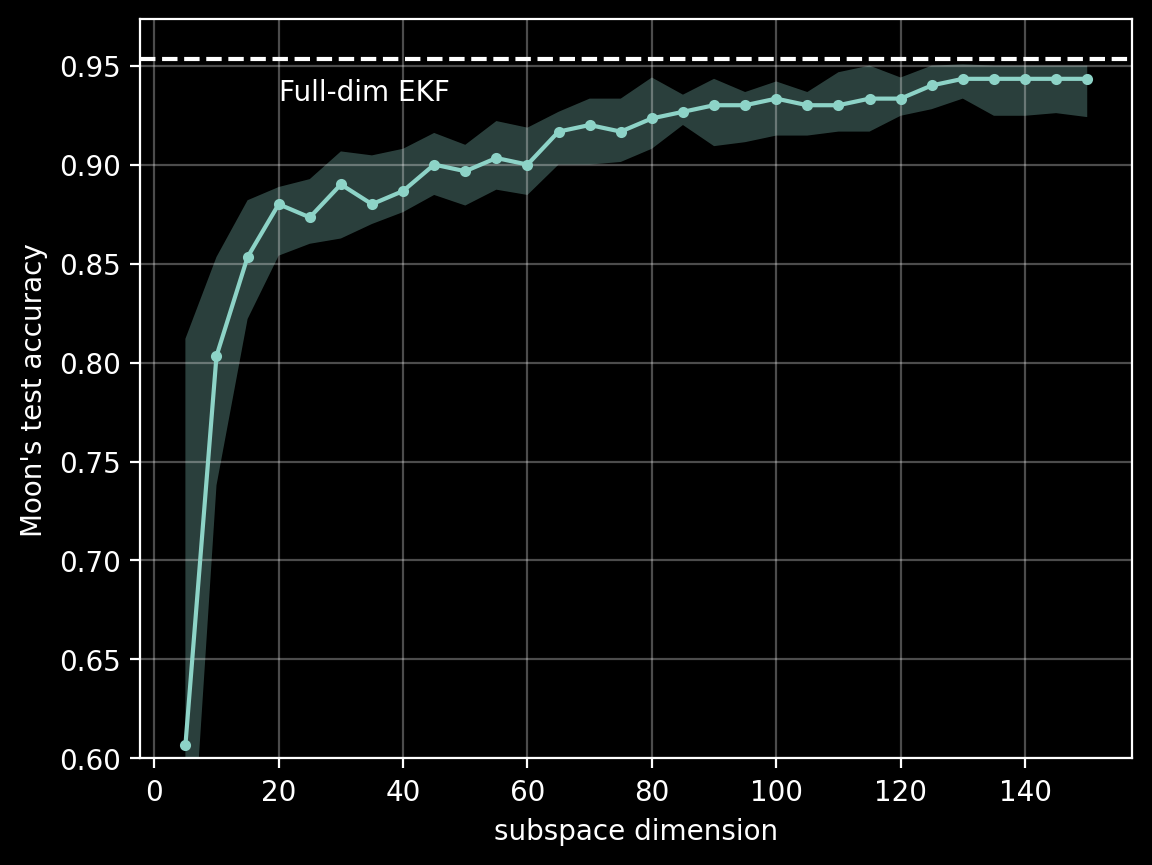

In [15]:
fig, ax = plt.subplots()

vmin = results.quantile(0.1, axis=1)
vmax = results.quantile(0.9, axis=1)

results.quantile(axis=1).plot(ax=ax, marker="o", markersize=3)
ax.fill_between(results.index, vmin, vmax, alpha=0.3)
ax.axhline(y=acc_full, linestyle="--")
ax.text(20, acc_full * (1 - 0.01), "Full-dim EKF", verticalalignment="top")

_, ymax = plt.ylim()
plt.ylim(0.6, ymax)

plt.xlabel("subspace dimension")
plt.ylabel("Moon's test accuracy")
plt.grid(alpha=0.3)

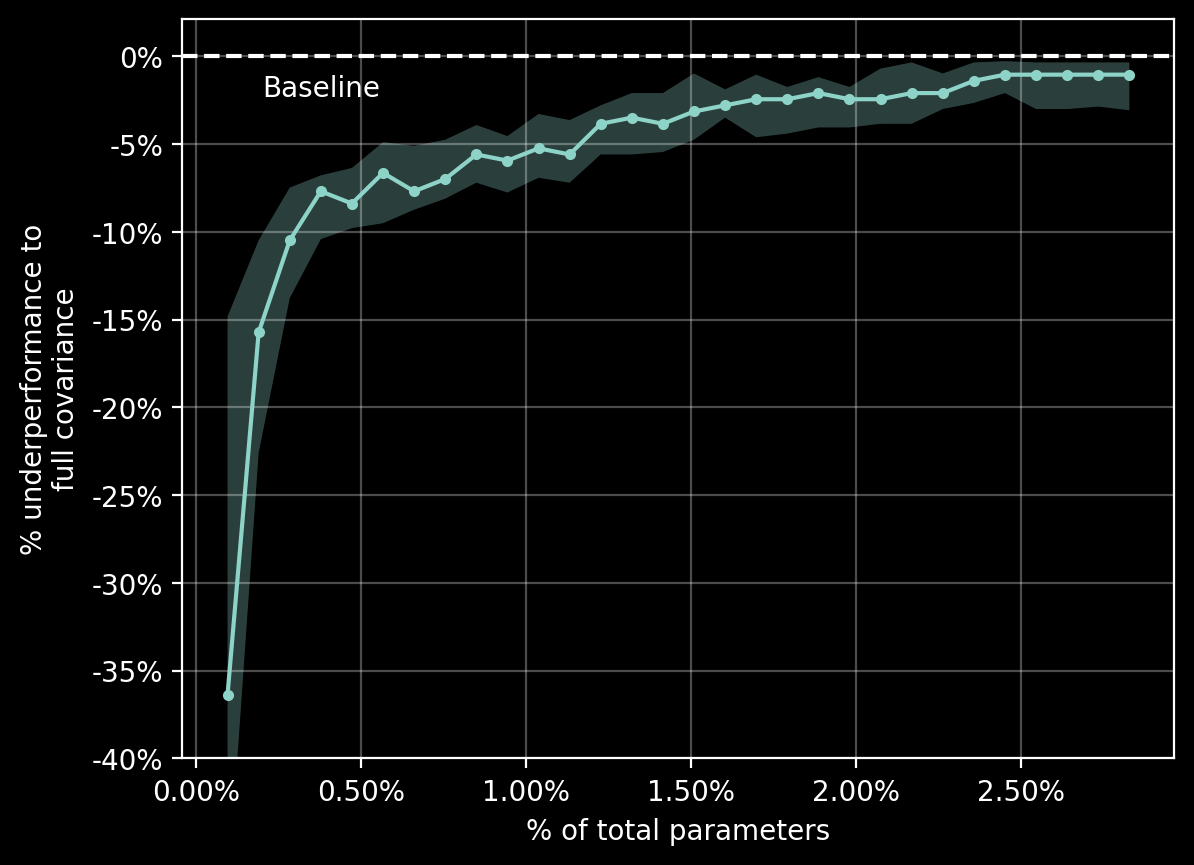

In [25]:
fig, ax = plt.subplots()

underperformance = results / acc_full - 1
underperformance.index = underperformance.index / dim_full
vmin = underperformance.quantile(0.1, axis=1)
vmax = underperformance.quantile(0.9, axis=1)

underperformance.quantile(axis=1).plot(ax=ax, marker="o", markersize=3)
ax.fill_between(underperformance.index, vmin, vmax, alpha=0.3)

_, ymax = plt.ylim()
plt.ylim(-0.4, ymax)

ax.axhline(y=0.0, linestyle="--")
ax.text(0.20e-2, -1e-2, "Baseline", verticalalignment="top")

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:0.2%}"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:0.0%}"))

plt.xlabel("% of total parameters")
plt.ylabel("% underperformance to\nfull covariance")
plt.grid(alpha=0.3)

--- 

# Fashion MNIST

In [6]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
# X_train = einops.rearrange(X_train, "s w h -> s (w h)") / 255
# X_test = einops.rearrange(X_test, "s w h -> s (w h)") / 255
X_train = X_train[..., None] / 255
X_test = X_test[..., None] / 255 
y_train = jax.nn.one_hot(y_train, 10)
X_train = jnp.array(X_train)

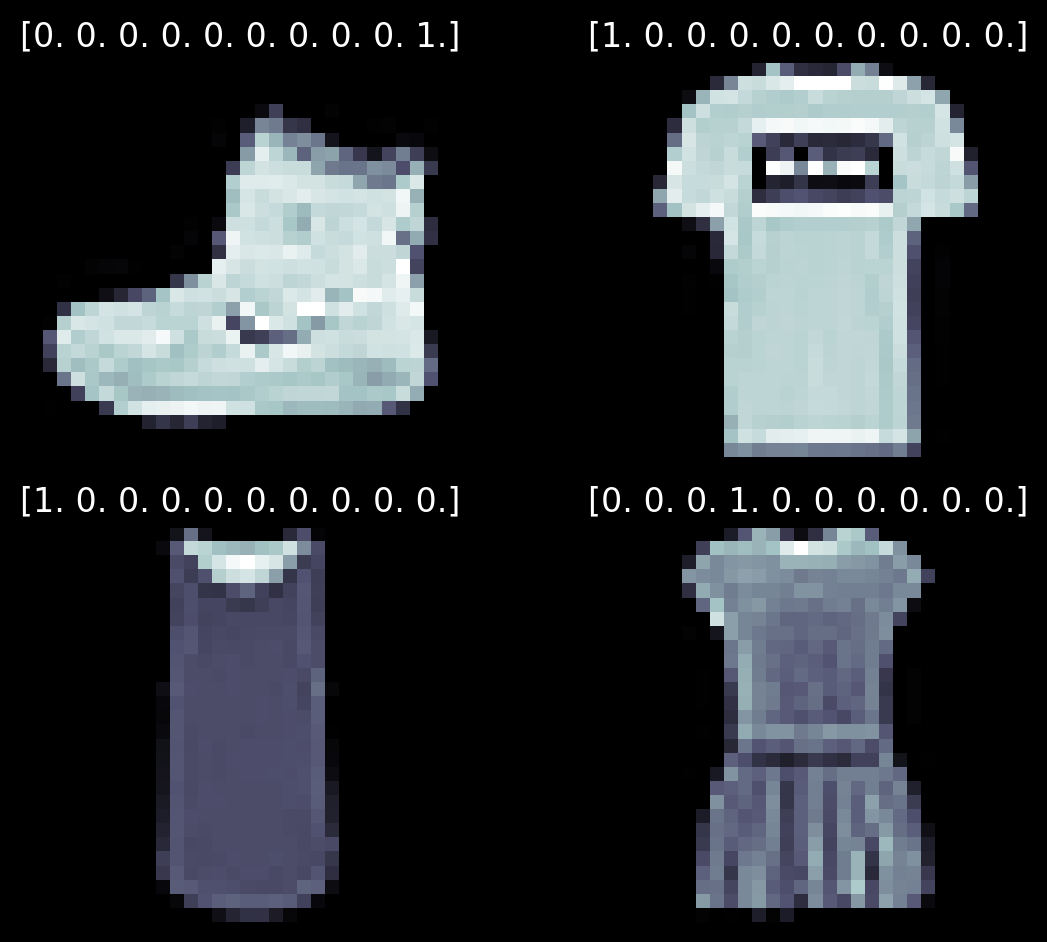

In [7]:
fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(axs.ravel()):
    ax.imshow(X_train[i], cmap="bone")
    ax.set_title(y_train[i])
    ax.axis("off")
plt.tight_layout()

In [8]:
X_eval = X_test[:5_000]
y_eval = y_test[:5_000]
def callbackfn(bel_update, bel_prev, y, x, agent):
    """
    Compute test accuracy at every timestep
    """
    yhat_eval = agent.link_fn(bel_update.mean, X_eval).argmax(axis=1)
    acc = (yhat_eval == y_eval).mean()
    return acc

## Subspace EKF

In [51]:
dim_in = (28, 28, 1)

In [55]:
class CNN(nn.Module):
    num_arms: int = 10

    @nn.compact
    def __call__(self, x):
        x = x if len(x.shape) > 3 else x[None, :]
        x = nn.Conv(features=6, kernel_size=(5, 5))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = nn.Conv(features=16, kernel_size=(5, 5), padding="VALID")(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=120)(x)
        x = nn.relu(x)
        x = nn.Dense(features=84, name="last_layer")(x)  # There are 10 classes in MNIST
        x = nn.relu(x)
        x = nn.Dense(10, name="output_layer")(x)
        x = x - jax.nn.logsumexp(x)
        return x.squeeze()
    
model = CNN()

In [56]:
dim_subspace = 100
model = skf.subcify(CNN)(dim_in=dim_in, dim_subspace=dim_subspace)

key_params, key_fixed = jax.random.split(key)
params = model.init(key, X_train)

In [57]:
agent = skf.MultinomialFilter(
    model.apply,
    dynamics_covariance=1e-7
)

In [13]:
%%time
bel_init = agent.init_bel(params, cov=1e-4)

cfn = partial(callbackfn, agent=agent)
bel, hist_subspace_random = agent.scan(bel_init, y_train[:10_000], X_train[:10_000], cfn)
bel = jax.block_until_ready(bel)

CPU times: user 18.8 s, sys: 334 ms, total: 19.1 s
Wall time: 33.2 s


In [14]:
yhat_eval = agent.link_fn(bel.mean, X_eval).argmax(axis=1)
confusion_matrix(y_eval, yhat_eval)

array([[  3,   0, 504,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 481,   0,   0,   0,   0,   0,   0,   0],
       [ 79,   0, 442,   0,   0,   0,   0,   0,   0,   0],
       [  4,   0, 496,   0,   0,   0,   0,   0,   0,   0],
       [161,   0, 360,   0,   0,   0,   0,   0,   0,   0],
       [ 30,   4, 451,   0,   0,   0,   0,   0,   0,   0],
       [ 48,   0, 434,   0,   0,   0,   0,   0,   0,   0],
       [  2,  34, 464,   0,   0,   0,   0,   0,   0,   0],
       [ 95,  52, 379,   0,   0,   0,   0,   0,   0,   0],
       [ 44, 191, 242,   0,   0,   0,   0,   0,   0,   0]])

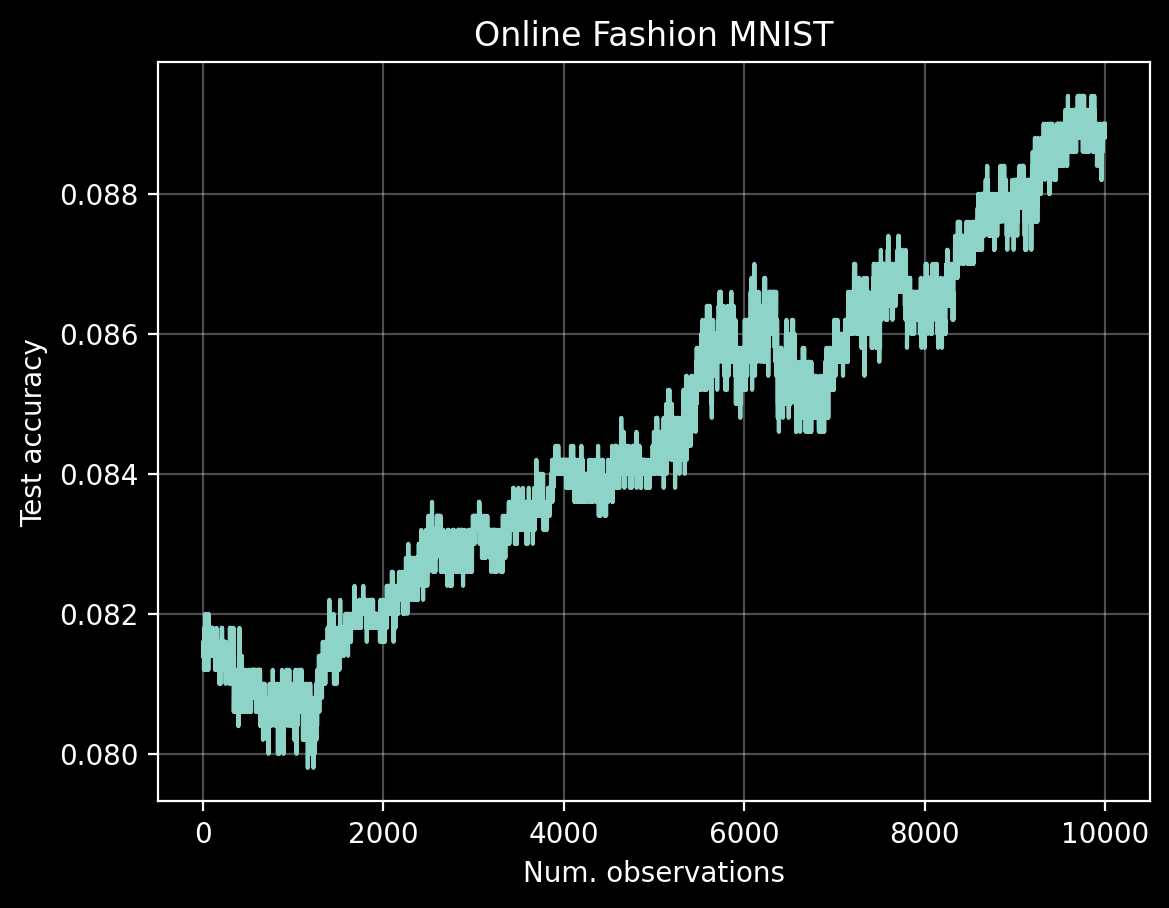

In [15]:
plt.plot(hist_subspace_random)

plt.xlabel("Num. observations")
plt.ylabel("Test accuracy")
plt.title("Online Fashion MNIST")
plt.grid(alpha=0.3)

## Subspace EKF with warmup

In [58]:
model = CNN()
def lossfn(params, X, y):
    yhat = model.apply(params, X)
    return -(y * yhat).sum(axis=1).mean()


def extract_hidden_layers(params):
    hidden_layers = deepcopy(params["params"])
    _ = hidden_layers.pop("output_layer")
    hidden_layers, _ = ravel_pytree(hidden_layers)
    return hidden_layers

In [59]:
X_warm = X_test[-2000:]
y_warm = jax.nn.one_hot(y_test[-2000:], 10)

In [60]:
pinit = model.init(key, X_train[:100])
state = TrainState.create(
    apply_fn=model.apply,
    params=pinit,
    tx=optax.adam(1e-3)
)

In [61]:
%%time
def warm_step(state, _):
    loss, grads = jax.value_and_grad(lossfn)(state.params, X_warm, y_warm)
    state = state.apply_gradients(grads=grads)
    
    params_flat, _ = ravel_pytree(state.params)
    # params_flat = extract_hidden_layers(state.params)
    output = {
        "params": params_flat,
        "loss": loss
    }
    return state, output

steps = jnp.arange(100)
state_final, hist_warmup = jax.lax.scan(warm_step, state, steps)

CPU times: user 23.6 s, sys: 89 ms, total: 23.7 s
Wall time: 12.8 s


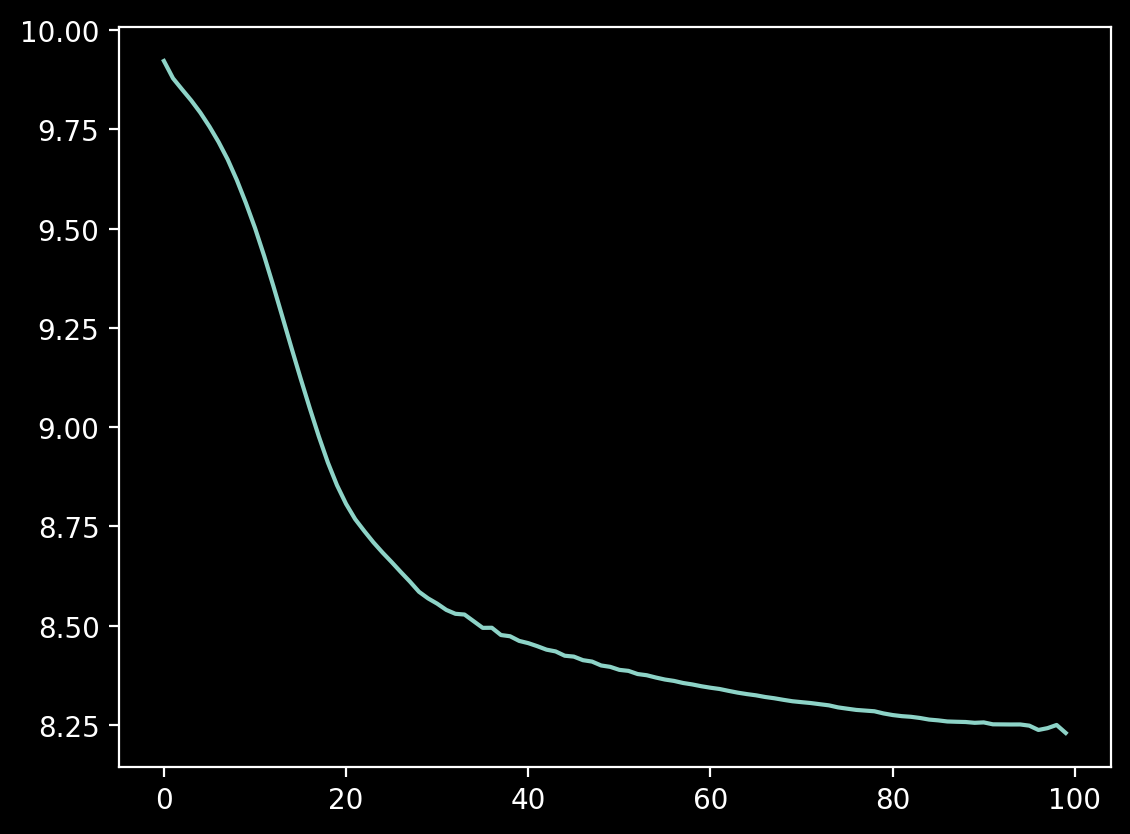

In [62]:
plt.plot(hist_warmup["loss"])

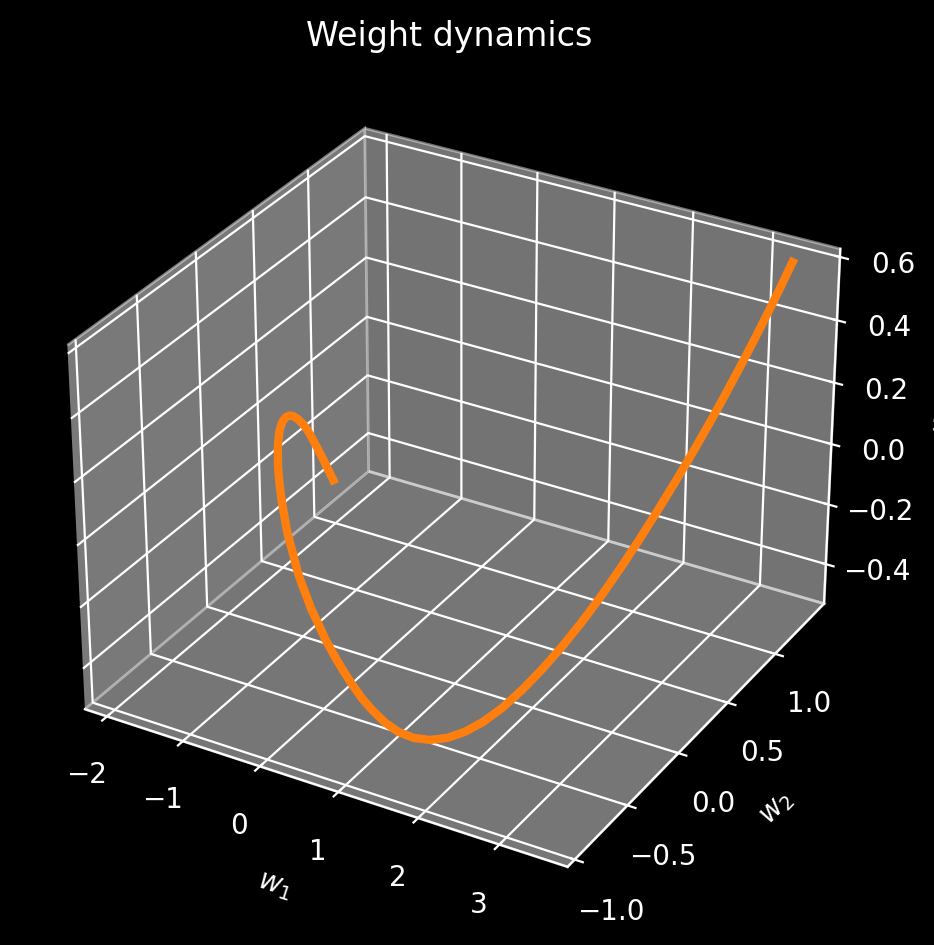

In [63]:
params_dynamics = np.array(hist_warmup["params"])

proj = PCA(n_components=3)
dynamics = proj.fit_transform(params_dynamics)

ax = plt.subplot(projection="3d")
plt.title("Weight dynamics")
ax.set_zlabel("$w_0$")
ax.set_xlabel("$w_1$")
ax.set_ylabel("$w_2$")
ax.plot(*dynamics.T, c="tab:orange", lw=3)
plt.tight_layout()

In [64]:
%%time
_, s, Vh = np.linalg.svd(params_dynamics, full_matrices=False)

projection_matrix = Vh[:dim_subspace, :].T
projection_matrix.shape

CPU times: user 1min 17s, sys: 1min 2s, total: 2min 20s
Wall time: 1.54 s


(61706, 100)

## Subspace EKF

In [65]:
model = skf.subcify(CNN)(dim_in=dim_in, dim_subspace=dim_subspace)

key_params, key_fixed = jax.random.split(key)
params = model.init(key, X_train)

params["fixed"]["P"] = projection_matrix * 24

In [66]:
agent = skf.MultinomialFilter(
    model.apply,
    dynamics_covariance=1e-7
)

In [67]:
%%time
bel_init = agent.init_bel(params, cov=1e-3)

cfn = partial(callbackfn, agent=agent)
bel, hist_subspace_svd = agent.scan(bel_init, y_train[:10_000], X_train[:10_000], cfn)
bel = jax.block_until_ready(bel)

CPU times: user 19.8 s, sys: 301 ms, total: 20.1 s
Wall time: 32.9 s


In [68]:
yhat_eval = agent.link_fn(bel.mean, X_eval).argmax(axis=1)
confusion_matrix(y_eval, yhat_eval)

array([[391,   0,  63,  37,   0,   0,   8,   7,   1,   0],
       [264,   3,   4, 210,   0,   0,   0,   0,   0,   0],
       [183,   1, 157,  11,  16,   0, 150,   1,   2,   0],
       [120,  16,  23, 331,   0,   0,   4,   4,   1,   1],
       [249,   2,  59,  56,  41,   0, 110,   1,   2,   1],
       [  0,   0, 188,   4,   3,   0,  25, 203,   1,  61],
       [228,   2, 148,  26,  13,   0,  61,   2,   2,   0],
       [  0,   0,  28,   0,   0,   0,   0, 457,   0,  15],
       [ 34,   1, 260,  16,   8,   0,  44, 100,  60,   3],
       [  0,   0,   0,   0,   0,   0,   0,  93,   0, 384]])

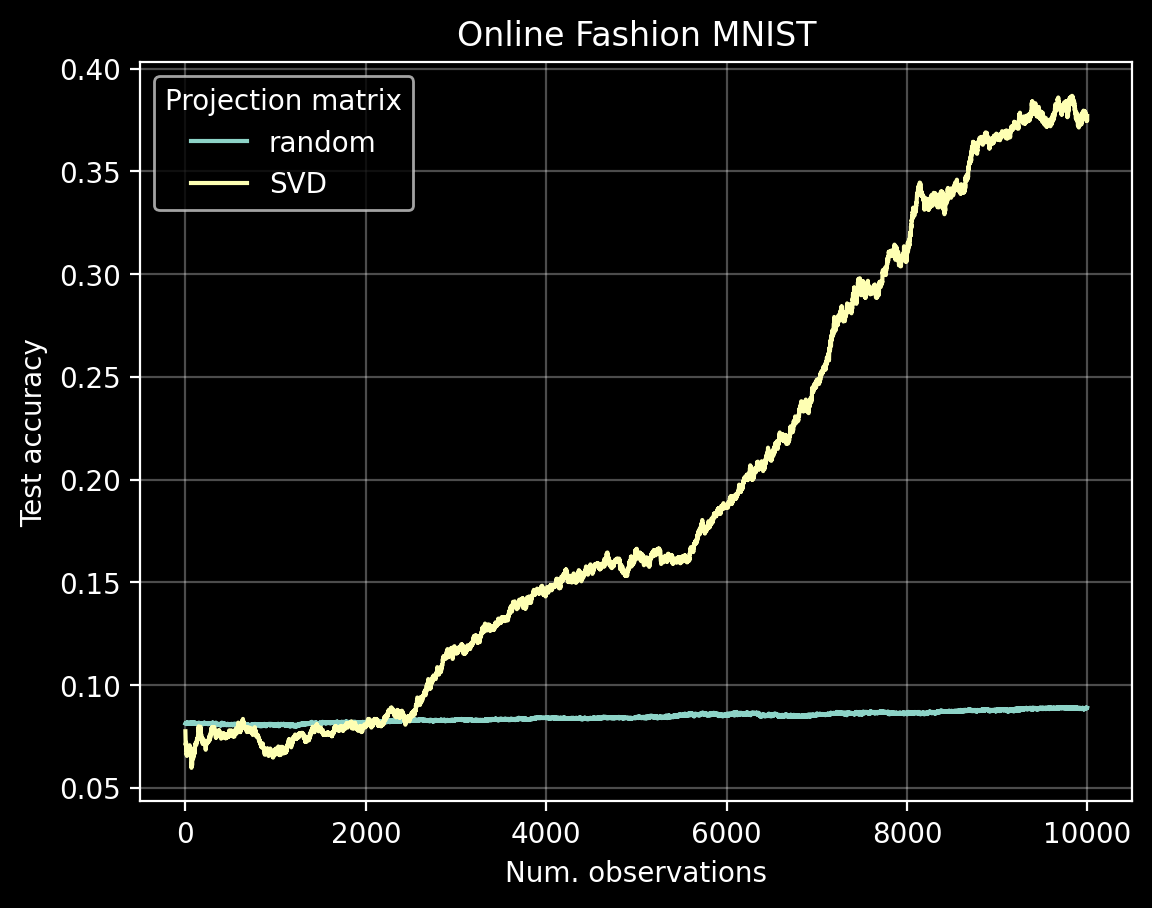

In [69]:
plt.plot(hist_subspace_random, label="random")
plt.plot(hist_subspace_svd, label="SVD")
plt.legend(title="Projection matrix")


plt.xlabel("Num. observations")
plt.ylabel("Test accuracy")
plt.title("Online Fashion MNIST")
plt.grid(alpha=0.3)

## PULSE

In [28]:
%%time
# @skf.subcify
class CNNHidden(nn.Module):
    num_arms: int = 10

    @nn.compact
    def __call__(self, x):
        x = x if len(x.shape) > 3 else x[None, :]
        x = nn.Conv(features=6, kernel_size=(5, 5))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = nn.Conv(features=16, kernel_size=(5, 5), padding="VALID")(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=120)(x)
        x = nn.relu(x)
        x = nn.Dense(features=84)(x)
        x = nn.relu(x)
        return x.squeeze()

    

class PULSE(nn.Module):
    dim_in: int
    dim_subspace: int

    @nn.compact
    def __call__(self, x):
        x = skf.subcify(CNNHidden)(self.dim_in, self.dim_subspace)(x)
        x = nn.Dense(10)(x)
        x = x - jax.nn.logsumexp(x)
        return x

CPU times: user 1.69 ms, sys: 0 ns, total: 1.69 ms
Wall time: 1.78 ms


In [29]:
dim_in = (28, 28, 1)
dim_subspace = 100
model = PULSE(dim_in=dim_in, dim_subspace=dim_subspace)

key_params, key_fixed = jax.random.split(key)
params = model.init({"params": key_params, "fixed": key_fixed}, X_train)

In [30]:
agent = skf.MultinomialFilter(
    model.apply,
    dynamics_covariance=1e-7
)

In [31]:
%%time
bel_init = agent.init_bel(params, cov=1e-4)
cfn = partial(callbackfn, agent=agent)
bel, hist_pulse_prandom = agent.scan(bel_init, y_train[:10_000], X_train[:10_000], cfn)
bel = jax.block_until_ready(bel)

CPU times: user 23 s, sys: 345 ms, total: 23.4 s
Wall time: 34.4 s


In [32]:
yhat_eval = agent.link_fn(bel.mean, X_eval).argmax(axis=1)
confusion_matrix(y_eval, yhat_eval)

array([[ 23,   1,  15,  56, 231,  15, 161,   2,   3,   0],
       [  6, 418,   4,  21,  27,   0,   5,   0,   0,   0],
       [  1,   0, 318,   7,  84,   6, 102,   0,   2,   1],
       [ 42,  31,   3, 290,  89,   5,  39,   0,   1,   0],
       [  3,   0, 264,  24, 168,   9,  49,   0,   3,   1],
       [  0,   0,   0,   8,   1, 200,  33, 192,  26,  25],
       [ 13,   1, 176,  28, 116,  21, 120,   1,   5,   1],
       [  0,   0,   0,   0,   0,  13,   0, 410,   2,  75],
       [  3,   0,  54,  56,   9,   8,  40,  42, 305,   9],
       [  0,   0,   0,  21,   0,   7,   3,  40,  30, 376]])

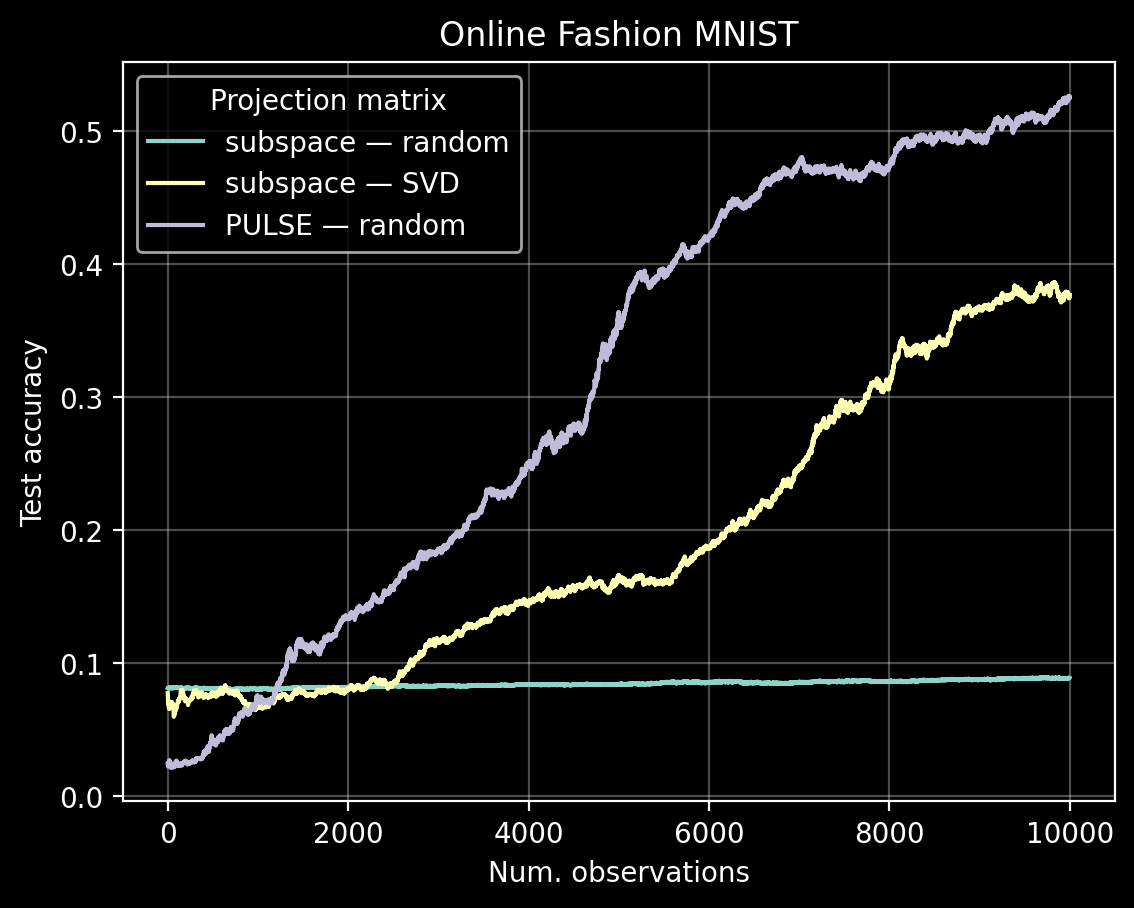

In [70]:
plt.plot(hist_subspace_random, label="subspace — random")
plt.plot(hist_subspace_svd, label="subspace — SVD")
plt.plot(hist_pulse_prandom, label="PULSE — random")
plt.legend(title="Projection matrix")


plt.xlabel("Num. observations")
plt.ylabel("Test accuracy")
plt.title("Online Fashion MNIST")
plt.grid(alpha=0.3)

## SVD PULSE

In [34]:
model = CNN()
def lossfn(params, X, y):
    yhat = model.apply(params, X)
    return -(y * yhat).sum(axis=1).mean()


def extract_hidden_layers(params):
    hidden_layers = deepcopy(params["params"])
    _ = hidden_layers.pop("output_layer")
    hidden_layers, _ = ravel_pytree(hidden_layers)
    return hidden_layers

In [35]:
X_warm = X_test[-1000:]
y_warm = jax.nn.one_hot(y_test[-1000:], 10)

In [36]:
pinit = model.init(key, X_train[:100])
state = TrainState.create(
    apply_fn=model.apply,
    params=pinit,
    tx=optax.adam(1e-3)
)

In [37]:
%%time
def warm_step(state, _):
    loss, grads = jax.value_and_grad(lossfn)(state.params, X_warm, y_warm)
    state = state.apply_gradients(grads=grads)
    
    # params_flat, _ = ravel_pytree(state.params)
    params_flat = extract_hidden_layers(state.params)
    output = {
        "params": params_flat,
        "loss": loss
    }
    return state, output

steps = jnp.arange(100)
state_final, hist_warmup = jax.lax.scan(warm_step, state, steps)

CPU times: user 11.6 s, sys: 264 ms, total: 11.8 s
Wall time: 4.94 s


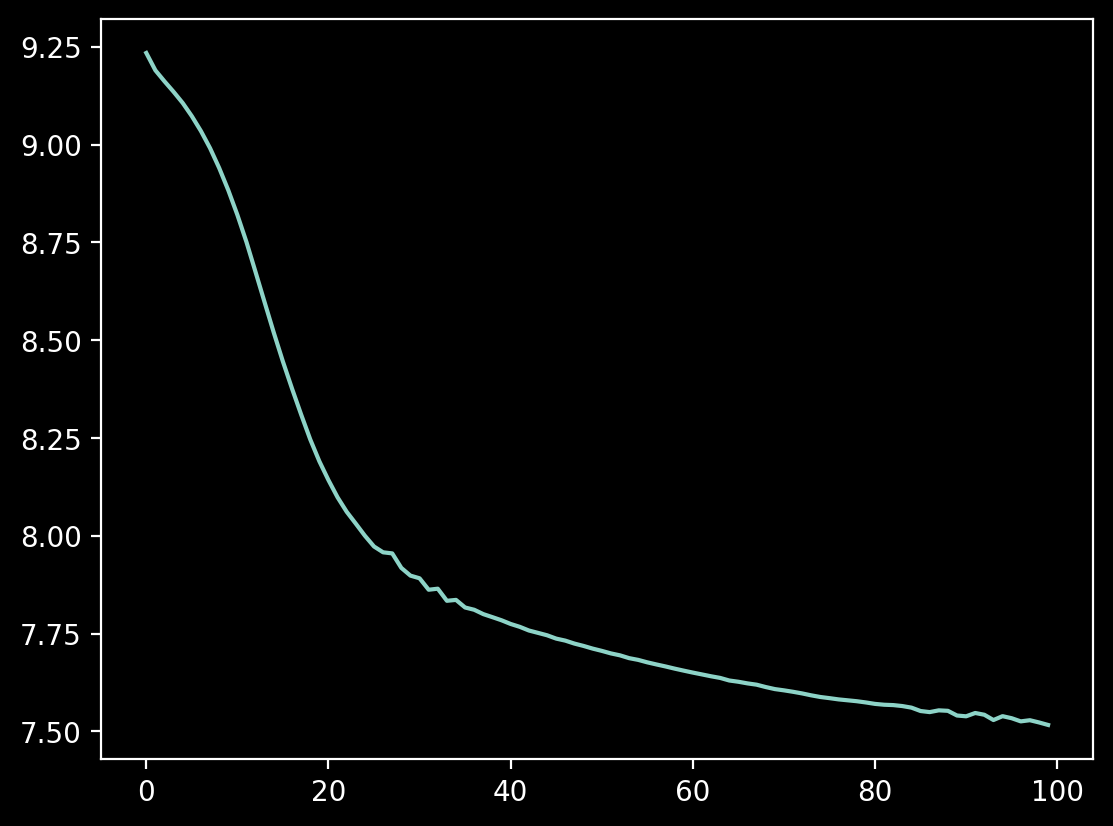

In [38]:
plt.plot(hist_warmup["loss"])

In [39]:
dim_subspace = 100

In [40]:
%%time
params_dynamics = hist_warmup["params"]
_, s, Vh = np.linalg.svd(params_dynamics, full_matrices=False)

projection_matrix = Vh[:dim_subspace, :].T
projection_matrix.shape

CPU times: user 1min 29s, sys: 1min 53s, total: 3min 23s
Wall time: 2.37 s


(60856, 100)

In [41]:
model = PULSE(dim_in=dim_in, dim_subspace=dim_subspace)

key_params, key_fixed = jax.random.split(key)
params = model.init({"params": key_params, "fixed": key_fixed}, X_train)

In [42]:
params["fixed"]["SubspaceModule_0"]["P"] = projection_matrix * 100
params = jax.tree_map(jnp.array, params) # Place back to TPU

In [43]:
agent = skf.MultinomialFilter(
    model.apply,
    dynamics_covariance=1e-8
)

In [44]:
from jax import config
config.update("jax_debug_nans", True)


In [45]:
%%time
bel_init = agent.init_bel(params, cov=1e-4)
cfn = partial(callbackfn, agent=agent)
bel, hist_pulse_svd = agent.scan(bel_init, y_train[:10_000], X_train[:10_000], cfn)
bel = jax.block_until_ready(bel)

CPU times: user 23.4 s, sys: 325 ms, total: 23.7 s
Wall time: 34.1 s


In [46]:
yhat_eval = agent.link_fn(bel.mean, X_eval).argmax(axis=1)
confusion_matrix(y_eval, yhat_eval)

array([[283,  26,   6,  48,  19,  21,  90,   6,   8,   0],
       [  3, 440,   5,  15,  14,   1,   2,   1,   0,   0],
       [  3,   3, 305,   7,  89,  18,  85,   0,  11,   0],
       [ 15,  70,   1, 330,  54,   5,  21,   1,   3,   0],
       [  0,  20, 209,  19, 203,   9,  54,   1,   5,   1],
       [  0,   0,   0,   3,   0, 297,   0, 148,   2,  35],
       [ 60,  10, 137,  31,  73,  40, 114,   2,  15,   0],
       [  0,   0,   0,   0,   0,  22,   0, 420,   0,  58],
       [  0,   2,  14,  12,   4,  12,  11,  35, 434,   2],
       [  0,   0,   2,   2,   0,  15,   0,  22,   2, 434]])

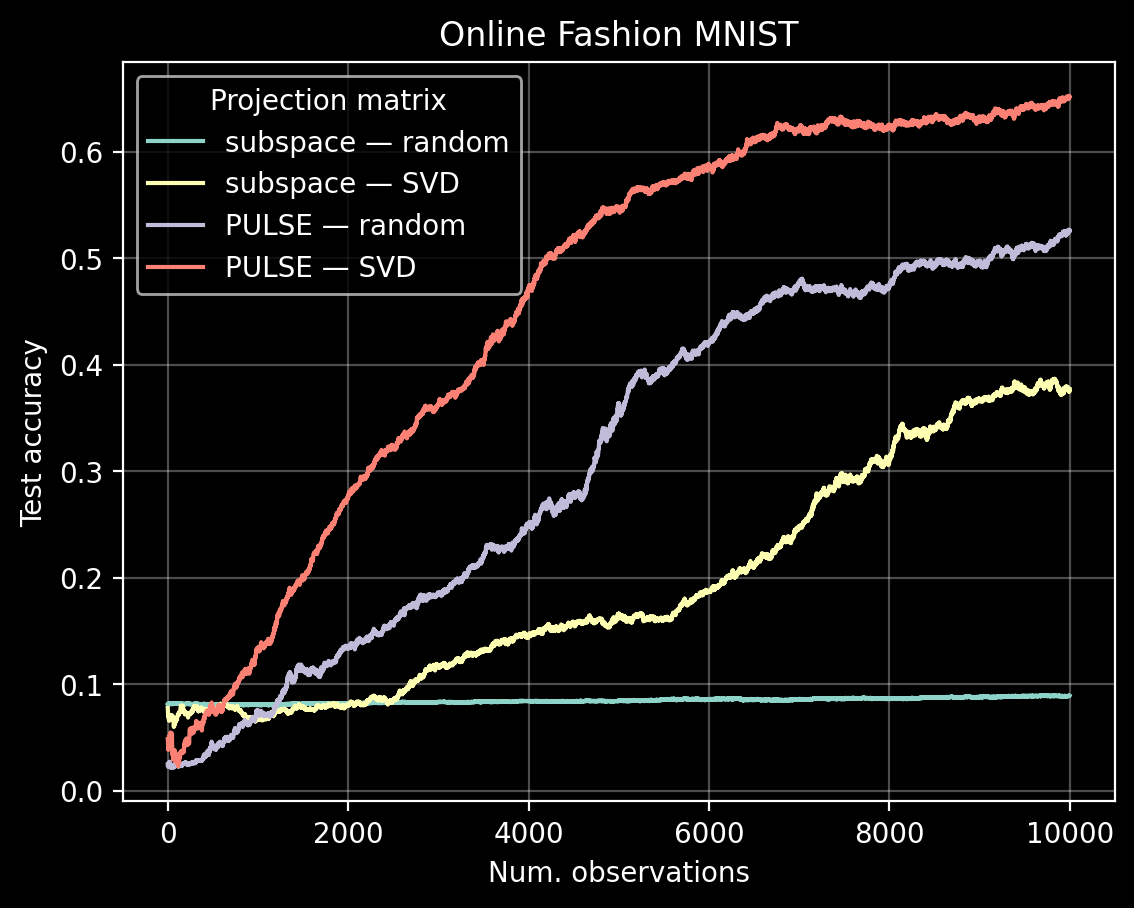

In [75]:
plt.plot(hist_subspace_random, label="subspace — random")
plt.plot(hist_subspace_svd, label="subspace — SVD")
plt.plot(hist_pulse_prandom, label="PULSE — random")
plt.plot(hist_pulse_svd, label="PULSE — SVD")
plt.legend(title="Projection matrix")


plt.xlabel("Num. observations")
plt.ylabel("Test accuracy")
plt.title("Online Fashion MNIST")
plt.grid(alpha=0.3)

## LoFi

In [48]:
model = CNN()
agent = lofi.MultinomialFilter(
    model.apply,
    dynamics_covariance=0.0,
    rank=100
)
params = model.init(key, X_train[:100])

In [49]:
%%time
bel_init = agent.init_bel(params, cov=1e-4)
cfn = partial(callbackfn, agent=agent)
bel, hist_lofi = agent.scan(bel_init, y_train[:10_000], X_train[:10_000], cfn)
bel = jax.block_until_ready(bel)

CPU times: user 41.4 s, sys: 1.01 s, total: 42.4 s
Wall time: 6min 42s


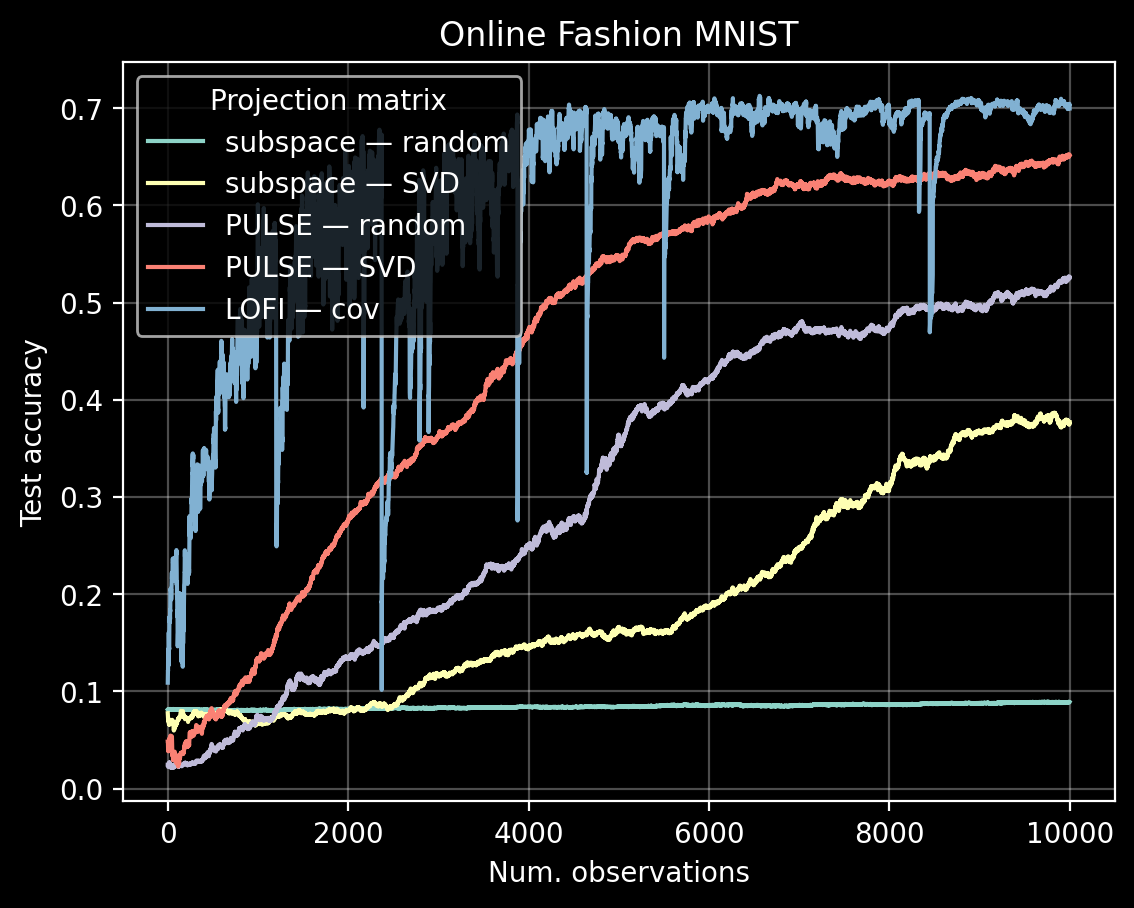

In [76]:
plt.plot(hist_subspace_random, label="subspace — random")
plt.plot(hist_subspace_svd, label="subspace — SVD")
plt.plot(hist_pulse_prandom, label="PULSE — random")
plt.plot(hist_pulse_svd, label="PULSE — SVD")
plt.plot(hist_lofi, label="LOFI — cov")
plt.legend(title="Projection matrix")


plt.xlabel("Num. observations")
plt.ylabel("Test accuracy")
plt.title("Online Fashion MNIST")
plt.grid(alpha=0.3)

## What about online-sgd?

In [92]:
X_eval = X_test[:5_000]
y_eval = y_test[:5_000]
def callbackfn(bel_update, bel_prev, y, x, agent):
    """
    Compute test accuracy at every timestep
    """
    yhat_eval = agent.apply_fn(bel_update.mean, X_eval).argmax(axis=1)
    acc = (yhat_eval == y_eval).mean()
    return acc

In [93]:
model = CNN()

In [94]:
def lossfn_fifo_sgd(params, counter, x, y, applyfn):
    yhat = applyfn(params, x)
    num = -(y * yhat).sum(axis=1) * counter
    return num.sum() / counter.sum()

In [122]:
agent = replay_sgd.FifoSGD(
    model.apply,
    lossfn_fifo_sgd,
    optax.sgd(1e-4),
    buffer_size=1,
    dim_features=(28, 28, 1),
    dim_output=10,
    n_inner=1
)

In [123]:
params_init = model.init(key, X_train[:10])

In [124]:
bel_init = agent.init_bel(params_init)

In [125]:
%%time
cfn = partial(callbackfn, agent=agent)
bel_sgd, hist_rsgd = agent.scan(bel_init, y_train[:10_000], X_train[:10_000], cfn)
bel_sgd = jax.block_until_ready(bel_sgd)

CPU times: user 9.82 s, sys: 88.4 ms, total: 9.91 s
Wall time: 27.2 s


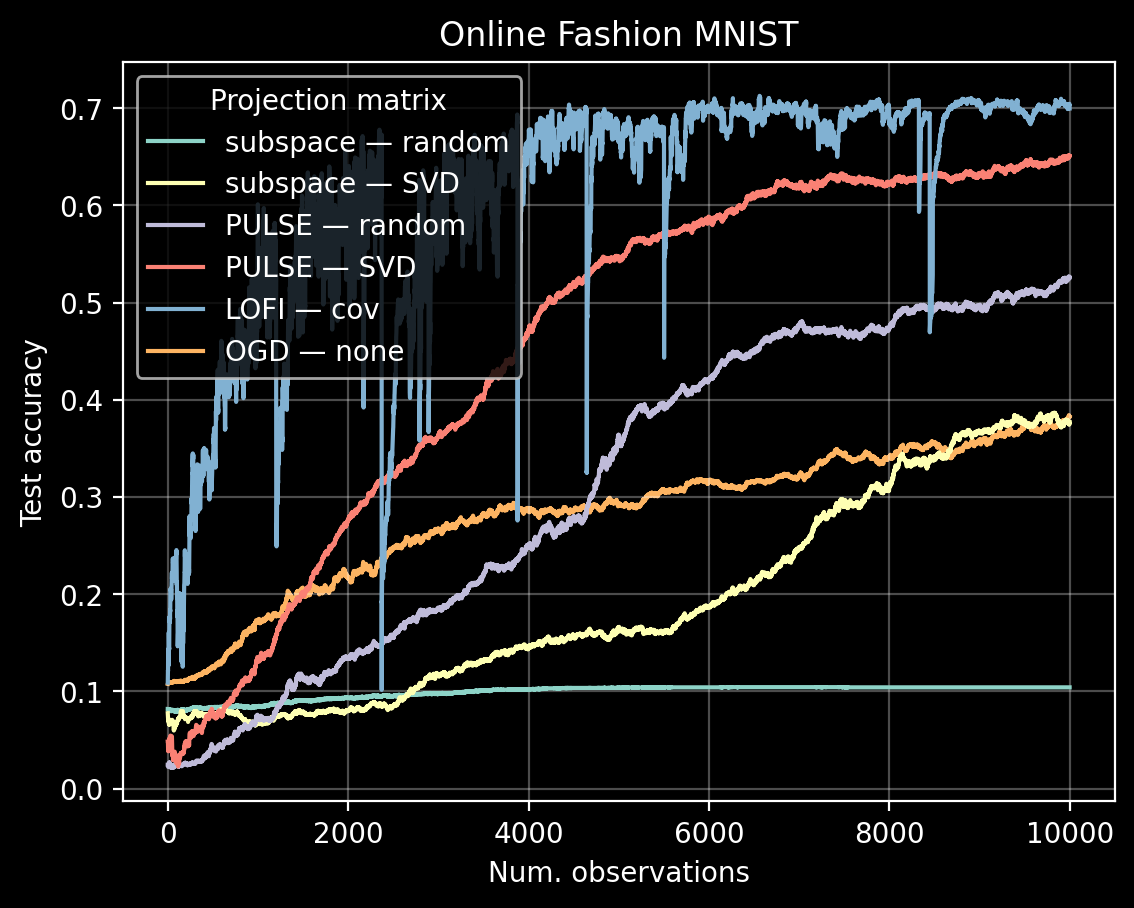

In [126]:
plt.plot(hist_subspace_random, label="subspace — random")
plt.plot(hist_subspace_svd, label="subspace — SVD")
plt.plot(hist_pulse_prandom, label="PULSE — random")
plt.plot(hist_pulse_svd, label="PULSE — SVD")
plt.plot(hist_lofi, label="LOFI — cov")
plt.plot(hist_rsgd, label="OGD — none", zorder=0)

plt.legend(title="Projection matrix")


plt.xlabel("Num. observations")
plt.ylabel("Test accuracy")
plt.title("Online Fashion MNIST")
plt.grid(alpha=0.3)